In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, History, Callback, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [2]:
def prepare_training_data(df_F, df_D, df_Dt, d):
    
    DF = []
    for i in range(d):
        if i == 0:
            DF = np.concatenate((df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis = 1)
        else:
            DF = np.concatenate((DF, df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis=1)

    DF = DF[d:,:]
    Dy = np.concatenate((df_D.values, df_Dt.values), axis=1)
    Dy = Dy[d:,:]
    
    return DF, Dy

In [3]:
def train_test_split(DF, Dy, d, x_scaler, y_scaler):

    dim = np.shape(Dy)

    n_nodes = int(dim[1]/2)
    n_y = dim[1]
    x = np.linspace(0,1, n_nodes)

    #Scaling
    DFscaled = x_scaler.transform(DF)
    Dyscaled = y_scaler.transform(Dy)

    X_train = DFscaled
    Y_train = Dyscaled

    #Train test split
    train_portion = 0.8
    n_timesteps = len(X_train[:,0])
    x_train = X_train[0:int(n_timesteps*train_portion),:]
    x_test = X_train[int(n_timesteps*(train_portion)):,:]
    y_train = Y_train[0:int(n_timesteps*train_portion),:]
    y_test = Y_train[int(n_timesteps*(train_portion)):,:]

    n_features = int(x_train.shape[1]/d)
    
    #Reshape training data into 3D array as required by the LSTM layer
    #Input shape is: (n_timesteps, d, n_features)
    x_train = x_train.reshape((x_train.shape[0], d, n_features))
    x_test = x_test.reshape((x_test.shape[0], d, n_features))

    return x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x

In [5]:
def get_error(predictions, y_test):
    #Squared error is integrated numerically in space for each timestep and summed
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((y_test[i,:] - predictions[i,:])**2, x)
    return error

In [6]:
def independent_predictions(x_test, my_model):

    input_i = np.copy(x_test[0,:,:]) #Initial conditions
    input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_test[:,0,0])-1
    preds = np.zeros([future_timesteps, n_y])

    force = np.copy(x_test[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known
    for i in range(future_timesteps): 
        pred = my_model.predict(input_i_reshaped) #Predict next timestep
        preds[i, :] = pred[0] 

        input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
        input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
        input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

        input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer
        
    return preds

In [7]:
def independent_batch(x_batch):

    input_i = np.copy(x_batch[0,:,:]) #Initial conditions
    input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_batch[:,0,0])

    force = np.copy(x_batch[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known
    
    ind_batch = np.zeros([future_timesteps, d, n_features])
    ind_batch[0] = input_i_reshaped[0]
    
    for i in range(future_timesteps): 
        pred = model.predict(input_i_reshaped) #Predict next timestep
        
        if i < future_timesteps - 1:
            input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
            input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
            input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

            input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer
            ind_batch[i+1] = input_i_reshaped[0]
        
    return ind_batch

In [8]:
def get_scalers(DF, Dy):
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x_scaler.fit_transform(DF)
    y_scaler.fit_transform(Dy)
    
    return x_scaler, y_scaler

In [18]:
def get_batch_scalers(n_batches, training_set):
    
    #Simple version
    for i in range(n_batches):
        
        df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(i+1) + '.csv')
        df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(i+1) + '.csv')
        df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(i+1) + '.csv')
        
        if i == 0:  
            x_range = df_D.values.max() - df_D.values.min()
            imax = i
        
        else:
            new_x_range = df_D.values.max() - df_D.values.min()
            
            if new_x_range > x_range:
                x_range = new_x_range
                imax = i
                
    df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(imax+1) + '.csv')
    df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(imax+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(imax+1) + '.csv')
    
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    return x_scaler, y_scaler

In [10]:
#columns = ['training set', 'n_layers', 'height', 'epochs', 'batch size', 'learning rate', 'early stopping', 'stop loss', 'Training Error', 'Test Error',
#           'Ind test error', 'Ind train error', 'Training time', 'Total time']
#df = pd.DataFrame(columns = columns)

#df.to_csv('../results/RNN_velocity_results.csv')

In [11]:
def get_batch(x_train, y_train, batch_size):
    
    start = random.randint(0,len(x_train)-batch_size)
    
    x_batch = x_train[start:start+batch_size]
    y_batch = y_train[start:start+batch_size]
    
    return x_batch, y_batch

In [19]:
n_batches = 1
d = 10

#Select training set
training_set = ''

x_scaler, y_scaler = get_batch_scalers(1, training_set) #Get global scalers

iteration = 0 
#Import training data
df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(iteration+1) + '.csv')
df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(iteration+1) + '.csv')
df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(iteration+1) + '.csv')

#Prepare training data
DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)

#Split into train and test set
x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)


In [16]:
class Ind_pred(Callback):
    
    def on_epoch_end(self, epoch, logs={}):

        input_i = np.copy(x_test[0,:,:]) #Initial conditions
        input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

        future_timesteps = len(x_test[:,0,0])-1
        preds = np.zeros([future_timesteps, n_y])

        force = np.copy(x_test[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known
        
        for i in range(future_timesteps): 
            pred = self.model.predict(input_i_reshaped) #Predict next timestep
            preds[i, :] = pred[0] 

            input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
            input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
            input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

            input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

        
        error = 0
        for i in range(len(preds[:,0])):
            error += np.trapz((y_test[i,:n_nodes] - preds[i,:n_nodes])**2, x)
        
        info = {'ind error': error}
        u_ind_errors.append(error)
        
        logs['ind_error'] = error
            
        print(info)
    
    #def on_batch_end(self, batch, logs={}):
    #    print(batch)

In [17]:
#u_errors_matrix = []
#c_errors_matrix =[]

In [31]:
def initialize_model(n_units, x_train, y_train, lr, n_layers):
    model = Sequential()
    
    #Add hidden layers, return_sequences=True if next layer is LSTM, False otherwise
    if n_layers == 1:
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
        
    elif n_layers == 2:
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        model.add(LSTM(n_units))
    else: 
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        for layer in range(n_layers-1):
            model.add(LSTM(n_units, return_sequences = True))
        model.add(LSTM(n_units))
    
    
    #model.add(Dropout(0.1))
    
    model.add(Dense(len(y_train[0,:]))) #Output Layer
    adam = Adam(lr=lr)
    model.compile(loss='mae', optimizer=adam)
    
    #Define callbacks
    ind_pred = Ind_pred()
    u_ind_errors = []
    history = History()
    earlystop = EarlyStopping(monitor='ind_error', min_delta=0.001, patience=10, verbose=1, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='ind_error', factor=0.2, patience=4, min_lr=0, mode='min', verbose=1)
    
    callback_list = [ind_pred, history, earlystop, reduce_lr]
    
    return model, callback_list

In [32]:
#columns = ['training set', 'n_layers', 'height', 'epochs', 'batch size', 'early stopping', 'stop loss', 'Training time', 'Total time']
#df = pd.DataFrame(columns = columns)

#df.to_csv('../results/RNN_velocity_architecture_test.csv')

In [ ]:
######################### BATCH TRAINING ########################################

#Hyperparameter settings
epochs = 500
layer_list = [1, 2, 3]
height_list = [20, 50, 100, 200, 500]
batch_size = 1000
lr = 0.001

counter = 1
t0 = time.time()

for n_layers in layer_list:
    for height in height_list:
        
        u_ind_errors = []
        u_model, callback_list = initialize_model(height, x_train, y_train, lr, n_layers)
        
        ts = time.time()
        hist = u_model.fit(x_train, y_train, epochs=epochs, callbacks=callback_list, batch_size=batch_size, 
                           verbose=1, shuffle=False)

        training_time = time.time() - ts
        total_time = time.time() - t0
        #Print results
        info = {'Iteration': counter, 'training set': training_set, 'n_layers': n_layers, 'height': height, 'epochs': epochs, 'batch size': batch_size, 
                        'early stopping': len(hist.history['ind_error']), 'stop ind error': hist.history['ind_error'][-1], 
                        'Training time': training_time, 'Total time': total_time}
        print(info)

        #Write results in results table
        df = pd.read_csv('../results/RNN_velocity_architecture_test.csv', index_col=0)

        df = df.append({'training set': training_set, 'n_layers': n_layers, 'height': height, 'epochs': epochs, 'batch size': batch_size, 
                        'early stopping': len(hist.history['ind_error']), 'stop ind error': hist.history['ind_error'][-1], 
                        'Training time': training_time, 'Total time': total_time}, ignore_index = True)

        df.to_csv('../results/RNN_velocity_architecture_test.csv')
        
        counter += 1
        u_errors_matrix.append(u_ind_errors)

Epoch 1/500
23992/23992 [==============================] - 2s 84us/step - loss: 0.3322
{'ind error': 423.06649855292085}
Epoch 2/500
23992/23992 [==============================] - 1s 49us/step - loss: 0.1874
{'ind error': 107.45028893894036}
Epoch 3/500
23992/23992 [==============================] - 1s 56us/step - loss: 0.1081
{'ind error': 38.780524685652914}
Epoch 4/500
23992/23992 [==============================] - 1s 56us/step - loss: 0.0754
{'ind error': 32.663460505774374}
Epoch 5/500
23992/23992 [==============================] - 1s 52us/step - loss: 0.0583
{'ind error': 24.985665763550635}
Epoch 6/500
23992/23992 [==============================] - 1s 52us/step - loss: 0.0471
{'ind error': 35.408274582671908}
Epoch 7/500
23992/23992 [==============================] - 1s 55us/step - loss: 0.0374
{'ind error': 22.668398043399169}
Epoch 8/500
23992/23992 [==============================] - 1s 51us/step - loss: 0.0300
{'ind error': 55.746076219613208}
Epoch 9/500
23992/23992 [=======

23992/23992 [==============================] - 2s 80us/step - loss: 0.0055
{'ind error': 6.8790562155250319}
Epoch 106/500
23992/23992 [==============================] - 2s 82us/step - loss: 0.0054
{'ind error': 6.8363317646682864}
Epoch 107/500
23992/23992 [==============================] - 2s 80us/step - loss: 0.0054
{'ind error': 6.7934739531829793}
Epoch 108/500
23992/23992 [==============================] - 2s 80us/step - loss: 0.0054
{'ind error': 6.7658622015021876}
Epoch 109/500
23992/23992 [==============================] - 2s 80us/step - loss: 0.0054
{'ind error': 6.7283030216071111}
Epoch 110/500
23992/23992 [==============================] - 2s 81us/step - loss: 0.0054
{'ind error': 6.6919841037005359}
Epoch 111/500
23992/23992 [==============================] - 2s 99us/step - loss: 0.0054
{'ind error': 6.653604182557836}
Epoch 112/500
23992/23992 [==============================] - 2s 93us/step - loss: 0.0054
{'ind error': 6.6258838370806394}
Epoch 113/500
23992/23992 [====

23992/23992 [==============================] - 2s 101us/step - loss: 0.0042
{'ind error': 4.6930392407200214}
Epoch 238/500
23992/23992 [==============================] - 2s 102us/step - loss: 0.0042
{'ind error': 4.6784890949071434}
Epoch 239/500
23992/23992 [==============================] - 2s 101us/step - loss: 0.0042
{'ind error': 4.6696558273362578}
Epoch 240/500
23992/23992 [==============================] - 2s 101us/step - loss: 0.0042
{'ind error': 4.6546506207918918}
Epoch 241/500
23992/23992 [==============================] - 2s 99us/step - loss: 0.0042
{'ind error': 4.6437766031198633}
Epoch 242/500
23992/23992 [==============================] - 3s 122us/step - loss: 0.0042
{'ind error': 4.6237589574053981}
Epoch 243/500
23992/23992 [==============================] - 2s 99us/step - loss: 0.0042
{'ind error': 4.6166836908031126}
Epoch 244/500
23992/23992 [==============================] - 2s 94us/step - loss: 0.0042
{'ind error': 4.5999501216696617}
Epoch 245/500
23992/23992

23992/23992 [==============================] - 2s 81us/step - loss: 0.0036
{'ind error': 3.3934629080429626}
Epoch 370/500
23992/23992 [==============================] - 2s 82us/step - loss: 0.0035
{'ind error': 3.436840220409497}
Epoch 371/500
23992/23992 [==============================] - 2s 81us/step - loss: 0.0035
{'ind error': 3.4224165378862068}
Epoch 372/500
23992/23992 [==============================] - 2s 82us/step - loss: 0.0035
{'ind error': 3.3930781880726832}
Epoch 373/500
23992/23992 [==============================] - 2s 86us/step - loss: 0.0035
{'ind error': 3.4185229996371542}
Epoch 374/500
23992/23992 [==============================] - 2s 85us/step - loss: 0.0035
{'ind error': 3.4043780507444827}
Epoch 375/500
23992/23992 [==============================] - 2s 85us/step - loss: 0.0035
{'ind error': 3.388776134246263}
Epoch 376/500
23992/23992 [==============================] - 2s 88us/step - loss: 0.0035
{'ind error': 3.3845286969213526}
Epoch 377/500
23992/23992 [=====

23992/23992 [==============================] - 4s 160us/step - loss: 0.0154
{'ind error': 19.559431646543363}
Epoch 7/500
23992/23992 [==============================] - 4s 161us/step - loss: 0.0146
{'ind error': 19.041034827099647}
Epoch 8/500
23992/23992 [==============================] - 4s 157us/step - loss: 0.0125
{'ind error': 14.047309529742925}
Epoch 9/500
23992/23992 [==============================] - 4s 159us/step - loss: 0.0114
{'ind error': 34.419978886707113}
Epoch 10/500
23992/23992 [==============================] - 4s 162us/step - loss: 0.0121
{'ind error': 22.620371228833285}
Epoch 11/500
23992/23992 [==============================] - 4s 167us/step - loss: 0.0120
{'ind error': 18.130729960138332}
Epoch 12/500
23992/23992 [==============================] - 4s 157us/step - loss: 0.0112
{'ind error': 16.645936837751343}

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 13/500
23992/23992 [==============================] - 4s 164us/step

{'ind error': 4.7646789999809149}
Epoch 71/500
23992/23992 [==============================] - 4s 158us/step - loss: 0.0049
{'ind error': 4.7493865397385955}
Epoch 72/500
23992/23992 [==============================] - 4s 168us/step - loss: 0.0049
{'ind error': 4.7356187481917669}
Epoch 73/500
23992/23992 [==============================] - 4s 161us/step - loss: 0.0049
{'ind error': 4.7227005532107613}
Epoch 74/500
23992/23992 [==============================] - 4s 175us/step - loss: 0.0049
{'ind error': 4.710304238515004}
Epoch 75/500
23992/23992 [==============================] - 4s 161us/step - loss: 0.0049
{'ind error': 4.6981951454796391}
Epoch 76/500
23992/23992 [==============================] - 4s 160us/step - loss: 0.0049
{'ind error': 4.6841621355818006}
Epoch 77/500
23992/23992 [==============================] - 4s 171us/step - loss: 0.0049
{'ind error': 4.6699494455956829}
Epoch 78/500
23992/23992 [==============================] - 4s 162us/step - loss: 0.0049
{'ind error': 4.6

23992/23992 [==============================] - 4s 157us/step - loss: 0.0044
{'ind error': 3.3376618717034781}
Epoch 203/500
23992/23992 [==============================] - 4s 164us/step - loss: 0.0044 0s - loss: 0.004
{'ind error': 3.3316166454386926}
Epoch 204/500
23992/23992 [==============================] - 4s 158us/step - loss: 0.0044
{'ind error': 3.3243393454426995}
Epoch 205/500
23992/23992 [==============================] - 4s 160us/step - loss: 0.0044
{'ind error': 3.3172388310982517}
Epoch 206/500
23992/23992 [==============================] - 4s 159us/step - loss: 0.0044
{'ind error': 3.3114800332944001}
Epoch 207/500
23992/23992 [==============================] - 4s 158us/step - loss: 0.0044
{'ind error': 3.3052184272820275}
Epoch 208/500
23992/23992 [==============================] - 4s 159us/step - loss: 0.0044
{'ind error': 3.2977484106964261}
Epoch 209/500
23992/23992 [==============================] - 4s 159us/step - loss: 0.0044
{'ind error': 3.2903419408447188}
Epoch

23992/23992 [==============================] - 4s 172us/step - loss: 0.0042
{'ind error': 2.9328069316574661}
Epoch 269/500
23992/23992 [==============================] - 4s 169us/step - loss: 0.0042
{'ind error': 2.9269128970527558}
Epoch 270/500
23992/23992 [==============================] - 4s 167us/step - loss: 0.0042
{'ind error': 2.9228159530100344}
Epoch 271/500
23992/23992 [==============================] - 4s 167us/step - loss: 0.0042
{'ind error': 2.9183653575441251}
Epoch 272/500
23992/23992 [==============================] - 4s 167us/step - loss: 0.0042
{'ind error': 2.914424312102434}
Epoch 273/500
23992/23992 [==============================] - 4s 176us/step - loss: 0.0042
{'ind error': 2.9075784846511605}
Epoch 274/500
23992/23992 [==============================] - 4s 170us/step - loss: 0.0042
{'ind error': 2.9031455768552132}
Epoch 275/500
23992/23992 [==============================] - 4s 169us/step - loss: 0.0042
{'ind error': 2.8991655896498774}
Epoch 276/500
23992/239

23992/23992 [==============================] - 4s 159us/step - loss: 0.0039
{'ind error': 2.3804451399994822}
Epoch 401/500
23992/23992 [==============================] - 4s 158us/step - loss: 0.0039
{'ind error': 2.3779167640159571}
Epoch 402/500
23992/23992 [==============================] - 4s 157us/step - loss: 0.0039
{'ind error': 2.3754724109883423}
Epoch 403/500
23992/23992 [==============================] - 4s 157us/step - loss: 0.0039
{'ind error': 2.372094135238112}
Epoch 404/500
23992/23992 [==============================] - 4s 159us/step - loss: 0.0039
{'ind error': 2.3693161031554797}
Epoch 405/500
23992/23992 [==============================] - 4s 157us/step - loss: 0.0039
{'ind error': 2.3629644585189178}
Epoch 406/500
23992/23992 [==============================] - 4s 157us/step - loss: 0.0038
{'ind error': 2.3606025458661439}
Epoch 407/500
23992/23992 [==============================] - 4s 156us/step - loss: 0.0038
{'ind error': 2.356824406165182}
Epoch 408/500
23992/2399

23992/23992 [==============================] - 4s 158us/step - loss: 0.0037
{'ind error': 2.1644479502944285}
Epoch 467/500
23992/23992 [==============================] - 4s 157us/step - loss: 0.0037
{'ind error': 2.1633786394226284}
Epoch 468/500
23992/23992 [==============================] - 4s 157us/step - loss: 0.0037
{'ind error': 2.1581558112935797}
Epoch 469/500
23992/23992 [==============================] - 4s 164us/step - loss: 0.0037
{'ind error': 2.1552325950070279}
Epoch 470/500
23992/23992 [==============================] - 4s 158us/step - loss: 0.0037
{'ind error': 2.1516921115793979}
Epoch 471/500
23992/23992 [==============================] - 4s 156us/step - loss: 0.0037
{'ind error': 2.1475863468673992}
Epoch 472/500
23992/23992 [==============================] - 4s 158us/step - loss: 0.0037
{'ind error': 2.1444063292458595}
Epoch 473/500
23992/23992 [==============================] - 4s 158us/step - loss: 0.0037
{'ind error': 2.1417137693177333}
Epoch 474/500
23992/23

23992/23992 [==============================] - 10s 406us/step - loss: 0.0042
{'ind error': 2.7338745214776043}
Epoch 94/500
23992/23992 [==============================] - 10s 405us/step - loss: 0.0042
{'ind error': 2.7322512351341621}
Epoch 95/500
23992/23992 [==============================] - 10s 415us/step - loss: 0.0042
{'ind error': 2.7307004523931155}
Epoch 96/500
23992/23992 [==============================] - 10s 405us/step - loss: 0.0042
{'ind error': 2.7294106839271342}
Epoch 97/500
23992/23992 [==============================] - 10s 407us/step - loss: 0.0042
{'ind error': 2.7280601261749227}
Epoch 98/500
23992/23992 [==============================] - 10s 405us/step - loss: 0.0042
{'ind error': 2.7267344752139113}
Epoch 99/500
23992/23992 [==============================] - 10s 404us/step - loss: 0.0042
{'ind error': 2.7253767340103026}
Epoch 100/500
23992/23992 [==============================] - 10s 411us/step - loss: 0.0042
{'ind error': 2.7243457140495115}
Epoch 101/500
23992/

23992/23992 [==============================] - 10s 405us/step - loss: 0.0041
{'ind error': 2.6231269604372858}
Epoch 160/500
23992/23992 [==============================] - 10s 403us/step - loss: 0.0041
{'ind error': 2.621235301428813}
Epoch 161/500
23992/23992 [==============================] - 10s 405us/step - loss: 0.0041
{'ind error': 2.6191749589679003}
Epoch 162/500
23992/23992 [==============================] - 10s 404us/step - loss: 0.0041
{'ind error': 2.6170149256892099}
Epoch 163/500
23992/23992 [==============================] - 10s 410us/step - loss: 0.0041
{'ind error': 2.6147417885353526}
Epoch 164/500
23992/23992 [==============================] - 10s 406us/step - loss: 0.0041
{'ind error': 2.6127642902344337}
Epoch 165/500
23992/23992 [==============================] - 10s 405us/step - loss: 0.0041
{'ind error': 2.6105304674308454}
Epoch 166/500
23992/23992 [==============================] - 10s 411us/step - loss: 0.0041
{'ind error': 2.608090424283779}
Epoch 167/500
23

{'ind error': 2.4618333650789443}
Epoch 225/500
23992/23992 [==============================] - 10s 402us/step - loss: 0.0041
{'ind error': 2.459254500414179}
Epoch 226/500
23992/23992 [==============================] - 10s 401us/step - loss: 0.0041
{'ind error': 2.4568064311520286}
Epoch 227/500
23992/23992 [==============================] - 10s 414us/step - loss: 0.0041
{'ind error': 2.4544088142153773}
Epoch 228/500
23992/23992 [==============================] - 10s 405us/step - loss: 0.0041
{'ind error': 2.4520597695050821}
Epoch 229/500
23992/23992 [==============================] - 10s 404us/step - loss: 0.0041
{'ind error': 2.4494770277121258}
Epoch 230/500
23992/23992 [==============================] - 11s 451us/step - loss: 0.0040
{'ind error': 2.4469914275734594}
Epoch 231/500
23992/23992 [==============================] - 10s 410us/step - loss: 0.0040
{'ind error': 2.4445705274506069}
Epoch 232/500
23992/23992 [==============================] - 10s 405us/step - loss: 0.0040
{

{'ind error': 2.1198076105298727}
Epoch 356/500
23992/23992 [==============================] - 10s 409us/step - loss: 0.0039
{'ind error': 2.1169561056718065}
Epoch 357/500
23992/23992 [==============================] - 10s 414us/step - loss: 0.0039
{'ind error': 2.1142388176260627}
Epoch 358/500
23992/23992 [==============================] - 10s 409us/step - loss: 0.0039
{'ind error': 2.1108905891517131}
Epoch 359/500
23992/23992 [==============================] - 10s 408us/step - loss: 0.0039
{'ind error': 2.1082757666825414}
Epoch 360/500
23992/23992 [==============================] - 10s 405us/step - loss: 0.0039
{'ind error': 2.1055451699514993}
Epoch 361/500
23992/23992 [==============================] - 10s 406us/step - loss: 0.0039
{'ind error': 2.1031550443472034}
Epoch 362/500
23992/23992 [==============================] - 10s 407us/step - loss: 0.0039
{'ind error': 2.1008818416132748}
Epoch 363/500
23992/23992 [==============================] - 10s 405us/step - loss: 0.0039


{'ind error': 1.7965600924764344}
Epoch 487/500
23992/23992 [==============================] - 10s 406us/step - loss: 0.0038
{'ind error': 1.7942529298372298}
Epoch 488/500
23992/23992 [==============================] - 10s 415us/step - loss: 0.0038
{'ind error': 1.7920069220098744}
Epoch 489/500
23992/23992 [==============================] - 10s 406us/step - loss: 0.0038
{'ind error': 1.7897462605333982}
Epoch 490/500
23992/23992 [==============================] - 10s 413us/step - loss: 0.0038
{'ind error': 1.7875323880866405}
Epoch 491/500
23992/23992 [==============================] - 10s 410us/step - loss: 0.0037
{'ind error': 1.7856528718526821}
Epoch 492/500
23992/23992 [==============================] - 10s 408us/step - loss: 0.0037
{'ind error': 1.7835975720004178}
Epoch 493/500
23992/23992 [==============================] - 10s 410us/step - loss: 0.0037
{'ind error': 1.7811653434001125}
Epoch 494/500
23992/23992 [==============================] - 10s 408us/step - loss: 0.0037


23992/23992 [==============================] - 2s 89us/step - loss: 0.0212
{'ind error': 17.598295550540325}
Epoch 11/500
23992/23992 [==============================] - 2s 84us/step - loss: 0.0193
{'ind error': 28.57804528149973}
Epoch 12/500
23992/23992 [==============================] - 2s 89us/step - loss: 0.0166
{'ind error': 22.481615065837552}

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 13/500
23992/23992 [==============================] - 2s 85us/step - loss: 0.0137
{'ind error': 10.826100016181577}
Epoch 14/500
23992/23992 [==============================] - 2s 85us/step - loss: 0.0128
{'ind error': 14.44122137667587}
Epoch 15/500
23992/23992 [==============================] - 2s 88us/step - loss: 0.0125
{'ind error': 14.347042244540914}
Epoch 16/500
23992/23992 [==============================] - 2s 86us/step - loss: 0.0123
{'ind error': 14.491087121540643}
Epoch 17/500
23992/23992 [==============================] - 2s 87us/step - loss

23992/23992 [==============================] - 27s 1ms/step - loss: 0.0056
{'ind error': 4.9445399040357234}
Epoch 29/500
23992/23992 [==============================] - 26s 1ms/step - loss: 0.0056
{'ind error': 5.0934569467885025}
Epoch 30/500
23992/23992 [==============================] - 26s 1ms/step - loss: 0.0056
{'ind error': 5.0799617707351254}
Epoch 31/500
23992/23992 [==============================] - 26s 1ms/step - loss: 0.0056
{'ind error': 5.0765273566406721}
Epoch 32/500
23992/23992 [==============================] - 27s 1ms/step - loss: 0.0056
{'ind error': 5.0722533766156328}

Epoch 00032: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 33/500
23992/23992 [==============================] - 27s 1ms/step - loss: 0.0056
{'ind error': 5.1116886490274469}
Epoch 34/500
23992/23992 [==============================] - 26s 1ms/step - loss: 0.0056
{'ind error': 5.1202640182262078}
Epoch 35/500
23992/23992 [==============================] - 27s 1ms/step - los

In [3]:
df = pd.read_csv('../results/RNN_velocity_architecture_test.csv', index_col=0)

In [4]:
df

,training set,n_layers,height,epochs,batch size,early stopping,stop loss,Training time,Total time,stop ind error
0,NaN,1,20,500,1000,24,NaN,209.969938,210.235642,16.376280
1,NaN,1,50,500,1000,425,NaN,7060.287053,7270.947829,2.830862
2,NaN,1,100,500,1000,500,NaN,5606.873606,12878.227515,2.043484
3,NaN,1,200,500,1000,500,NaN,9613.945879,22492.557392,1.765825
4,NaN,1,500,500,1000,102,NaN,7634.784600,30127.914546,2.010965
5,NaN,2,20,500,1000,23,NaN,319.529344,30448.090595,11.436686
6,NaN,2,50,500,1000,39,NaN,628.297829,31076.931865,4.776496
7,NaN,2,100,500,1000,37,NaN,853.830756,31931.316096,3.579890
8,NaN,2,200,500,1000,38,NaN,1779.408887,33711.493016,5.117740


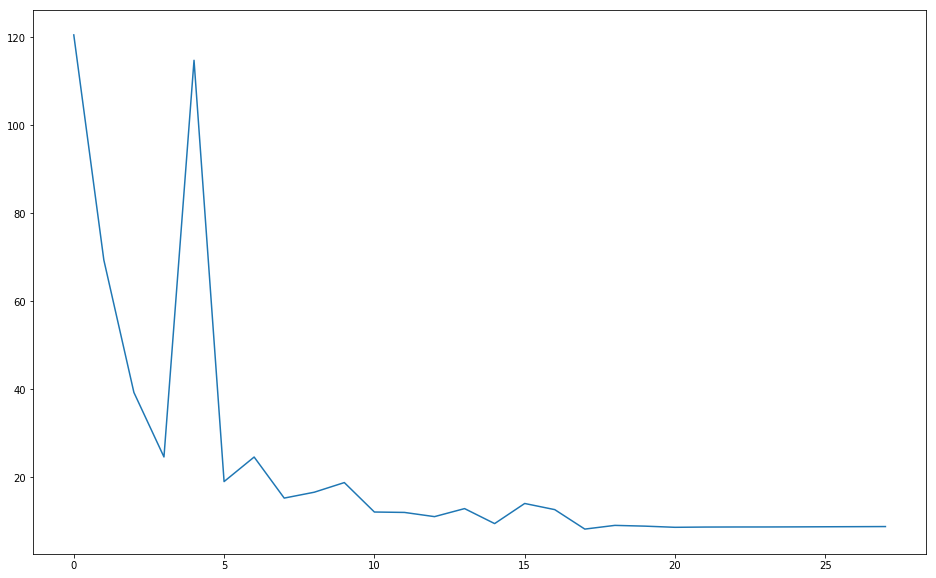

In [145]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(u_errors_matrix[0])
#plt.plot(c_ind_error)
plt.show()

In [146]:
np.array(u_errors_matrix)

array([[ 120.50553849,   69.33300448,   39.23126048,   24.56743535,
         114.73446446,   18.97193509,   24.54977661,   15.2157244 ,
          16.55055742,   18.74317989,   12.0495602 ,   11.95710951,
          11.00162658,   12.82591794,    9.41836339,   13.99090467,
          12.59388701,    8.16901013,    9.01311162,    8.83940604,
           8.57435572,    8.63230778,    8.64802911,    8.65123094,
           8.67079743,    8.69655673,    8.71869399,    8.74382999]])

In [135]:
pred_ind_all = independent_predictions(x_test, u_model)

In [136]:
pred_ind = pred_ind_all[:, 0:n_nodes]
ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])

In [138]:
print(ind_error)

8.74382999475


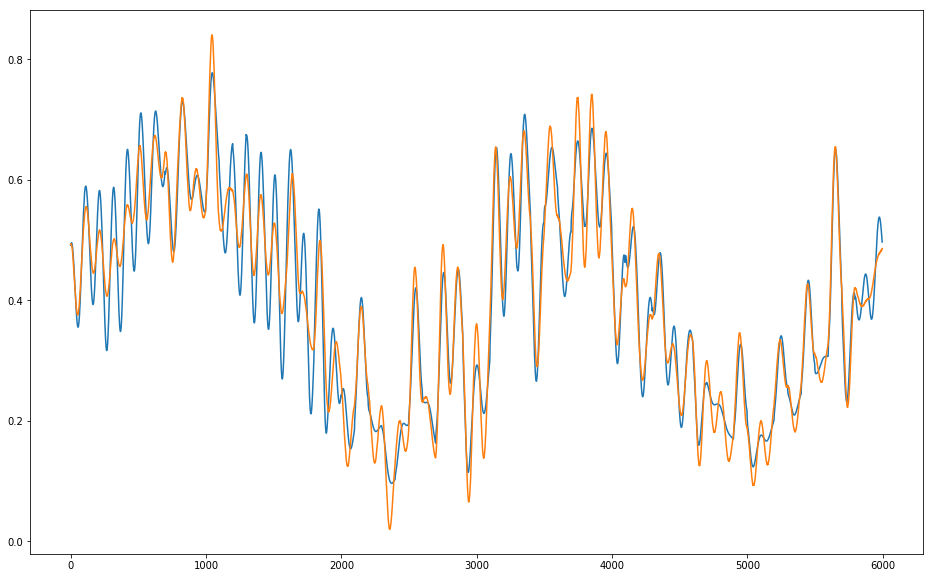

In [137]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(pred_ind[:,n_nodes-1])
plt.plot(y_test[:, n_nodes-1])
plt.show()

In [140]:
def generate_export(my_model):
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]

    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]

    pred_ind_all = independent_predictions(x_test, my_model)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]

    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]

In [141]:
generate_export(u_model)

In [142]:
#Export results
np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

In [232]:
# one layer, height 500, gives lowest error around 9, but this is while its heavily overfitting
# one layer, height 100, on gr_set1 goes down to about 6 at epoch 40, then starts overfitting
# same, but with height 200 starts oscillating around batch 20, then the ind error is around 9. 
# With dropout 0.1 the results are bad


#df = df.drop(columns=df.columns[0])
#df.to_csv('../results/RNN_velocity_results.csv')

In [233]:
#pd.read_csv('../results/RNN_velocity_results.csv', index_col=0)

,training set,n_layers,height,epochs,batch size,learning rate,early stopping,stop loss,Training Error,Test Error,Ind test error,Ind train error,Training time,Total time
0,rr,2,100,500,1000,0.0005,115,0.005931,0.428430,0.102271,4.126604,19.038270,2173.341693,2263.469776
1,rr,2,100,500,1000,0.0001,36,0.005536,0.457434,0.111018,18.604378,96.249718,707.928417,803.638126
2,rr,3,50,500,1000,0.0005,160,0.013542,0.497549,0.108562,11.480535,70.656266,5234.750504,5392.588225


In [129]:
#save best model
#trained on= gr_set1

#model.save('../models/RNN_gr_set1.h5')

#### CONTINUE TRAINING ####
#model = load_model('beam_model.h5')

#model.fit(x_train, y_train, epochs=100, verbose=1)

#model.save('beam_model.h5')

#del(model)

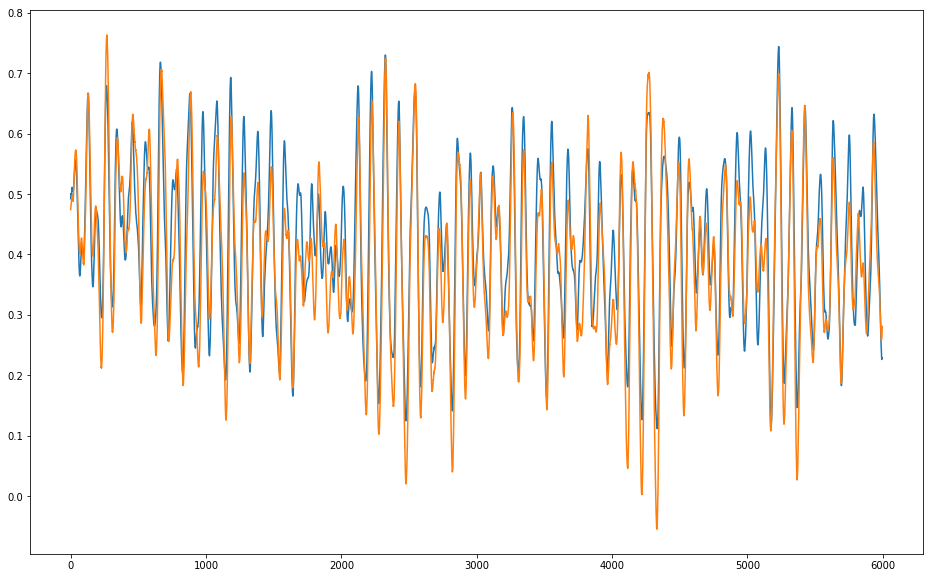

{'Iteration number': 1, 'Training Error': 1.7276860353577641, 'Test Error': 0.29846556877570002, 'Ind test error': 18.855915684260651, 'Training time': 0.0, 'Total time': 34.77224016189575}


In [32]:
######################### BATCH TESTING ########################################

n_batches = 1
#d = 8

t0 = time.time()
for iteration in range(n_batches):

    df_D = pd.read_csv('../training_batches/rrD' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('../training_batches/rrF' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/rrDt' + str(iteration+1) + '.csv')

    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #if i == 0:
    #    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    ts = time.time()
    #if i == 0:
    #    model, callback_list = initialize_model(100, x_train, y_train)
    
    #model.fit(x_train, y_train, epochs=100, callbacks=callback_list, batch_size=len(x_train), verbose=0, shuffle=False)
    
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    plt.figure(figsize=(16,10))
    #plt.plot(pred_test[:,n_nodes-1], 'x')
    plt.plot(pred_ind[:,n_nodes-1])
    plt.plot(y_test[:, n_nodes-1])
    plt.show()

    
    total_time = time.time() - t0
    
    info = {'Iteration number': iteration+1, 'Training Error': training_error, 'Test Error': test_error, 'Ind test error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    print(info)

In [202]:
#Export results
np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

In [203]:
pred_ind_all = independent_predictions(x_train)
pred_ind = pred_ind_all[:, 0:n_nodes]

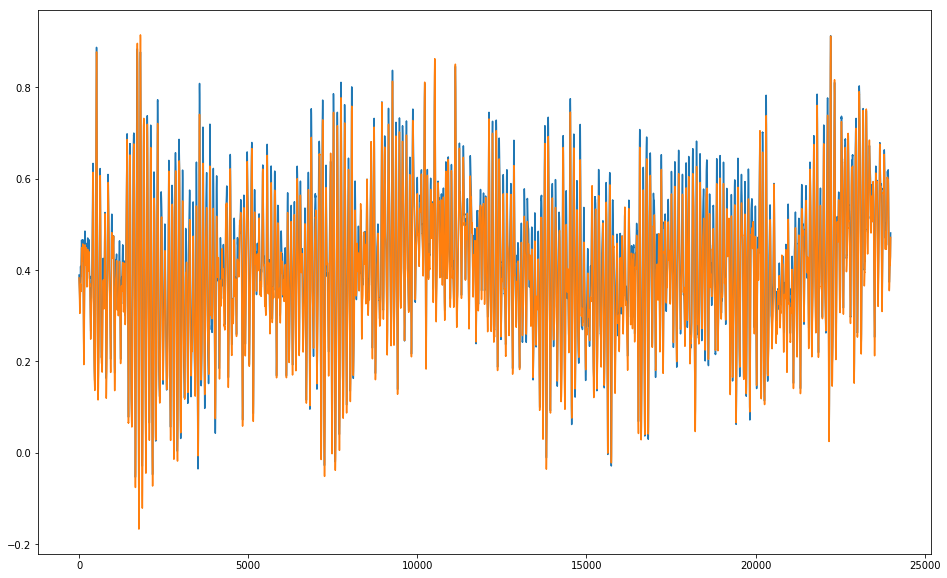

In [204]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(pred_ind[:,n_nodes-1])
plt.plot(y_train[:, n_nodes-1])
plt.show()

In [89]:
DF.shape

(4995, 205)

In [91]:
df_D.values.shape

(5000, 21)

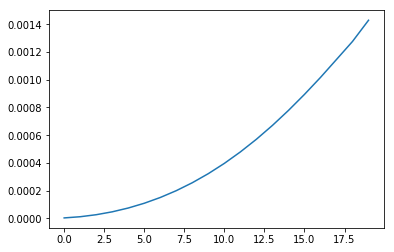

In [20]:
plt.plot(y_test_u[50,:])